In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning, parameter_learning_mix, component, n_component
from preprocess.discretization import get_nodes_type, discretization, inverse_discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from bayesian.subsample import get_subsample
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN
from bayesian.calculate_accuracy import calculate_acc, LOO_validation
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from copy import copy
from external.libpgm.sampleaggregator import SampleAggregator
import operator
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
import math
from pomegranate import DiscreteDistribution
import random
from sklearn.model_selection import train_test_split
from gmr import GMM
from gmr.utils import check_random_state
from gmr import MVN
from sklearn.datasets import make_spd_matrix
from sklearn.linear_model import LinearRegression
from sklearn.cluster import DBSCAN
from sklearn.covariance import EllipticEnvelope
from numpy import percentile
from scipy.stats import binned_statistic
from scipy.stats.distributions import chi2
import time
from scipy.stats.mstats import mquantiles

In [3]:
data = pd.read_csv('../data/mehra_small.csv')
data = data.drop(columns=['Unnamed: 0'])
columns = data.columns.tolist()
#columns = ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Hydrocarbon type', 'Depositional environment', 'Gross','Netpay','Porosity','Permeability', 'Depth']
data = data[columns]
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)

In [15]:
data

,Region,Zone,Type,Year,Season,Month,Day,Hour,Latitude,Longitude,...,tp,blh,ssr,CVD60,no2,o3,so2,co,pm10,pm2.5
0,North East,Greater London Urban Area,Background Urban,1990,Spring,8,24,10,53.655179,-2.305544,...,-0.001459,662.280368,2.786011e+06,0.181561,79.252291,15.651403,17.022254,1.861245,36.482165,18.644928
1,Greater London Authority,Greater Manchester Urban Area,Background Urban,1990,Spring,6,18,15,52.169178,1.248367,...,0.000469,1087.735424,6.089509e+06,0.130838,73.305754,17.736995,13.815516,1.440978,36.477873,18.644509
2,North West,West Midlands Urban Area,Background Suburban,2000,Spring,3,26,4,53.342171,0.150957,...,-0.000359,278.192858,-2.227710e+01,0.175086,45.900290,17.324375,7.007377,1.715333,31.453538,18.600452
3,Yorkshire and The Humber,South West,Background Urban,1998,Summer,12,18,15,52.970442,-2.017466,...,-0.002836,1218.678588,3.292414e+06,0.259490,93.176743,44.687525,3.690560,0.860158,29.312269,18.635924
4,West Midlands,Greater Manchester Urban Area,Background Urban,1987,Fall,11,16,6,55.696324,-1.469495,...,0.001244,637.860268,-4.335954e+04,0.176599,84.495807,17.747073,13.814152,1.442471,36.470048,18.638083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,West Midlands,West Midlands Urban Area,Traffic Urban,1989,Spring,5,14,12,52.941713,-3.946562,...,0.000619,1471.815204,6.540608e+06,0.172424,76.369681,17.734368,13.808683,1.441840,36.480640,18.641042
296,South East,Eastern,Background Urban,1986,Fall,9,16,8,51.121155,-0.574853,...,-0.000029,396.035781,-3.849786e+05,0.155859,76.379471,17.762546,13.807629,1.441331,36.482705,18.641272
297,South East,North West & Merseyside,Traffic Urban,2000,Winter,4,22,20,51.550349,-2.030388,...,0.001704,529.786529,3.679041e+06,0.174204,76.356513,17.753696,13.805590,1.441359,36.481064,18.183533
298,South West,Yorkshire & Humberside,Traffic Urban,2000,Spring,12,30,6,54.191283,-1.495950,...,0.001482,370.311308,1.185330e+04,0.145706,76.333842,17.779973,13.809527,1.442288,35.180410,18.644225


In [4]:
data['Year'] = data['Year'].apply(lambda x: str(x))
data['Month'] = data['Month'].apply(lambda x: str(x))
data['Day'] = data['Day'].apply(lambda x: str(x))
data['Hour'] = data['Hour'].apply(lambda x: str(x))

In [5]:
node_types = get_nodes_type(data)
node_types

{'Region': 'disc',
 'Zone': 'disc',
 'Type': 'disc',
 'Year': 'disc',
 'Season': 'disc',
 'Month': 'disc',
 'Day': 'disc',
 'Hour': 'disc',
 'Latitude': 'cont',
 'Longitude': 'cont',
 'Altitude': 'cont',
 't2m': 'cont',
 'ws': 'cont',
 'wd': 'cont',
 'tp': 'cont',
 'blh': 'cont',
 'ssr': 'cont',
 'CVD60': 'cont',
 'no2': 'cont',
 'o3': 'cont',
 'so2': 'cont',
 'co': 'cont',
 'pm10': 'cont',
 'pm2.5': 'cont'}

In [6]:
node_signs = get_nodes_sign(data)
node_signs

{'Latitude': 'pos',
 'Longitude': 'neg',
 'Altitude': 'neg',
 't2m': 'pos',
 'ws': 'neg',
 'wd': 'neg',
 'tp': 'neg',
 'blh': 'neg',
 'ssr': 'neg',
 'CVD60': 'pos',
 'no2': 'neg',
 'o3': 'neg',
 'so2': 'neg',
 'co': 'pos',
 'pm10': 'pos',
 'pm2.5': 'pos'}

In [7]:
colums_for_code = []
columns_for_disc = []
for c in columns:
    if node_types[c] == 'disc':
        colums_for_code.append(c)
    else:
        columns_for_disc.append(c)

In [7]:
data_coded, label_coder = code_categories(data, 'label', colums_for_code)
data_discrete, coder = discretization(data_coded, 'equal_frequency', columns_for_disc)

In [8]:
bn_full = structure_learning(data_discrete, 'HC', node_types, 'K2')

In [8]:
bn_full = dict()
bn_full['E'] = [['Region', 'wd'],
 ['Region', 'blh'],
 ['Region', 'CVD60'],
 ['Region', 'pm2.5'],
 ['Zone', 'no2'],
 ['Zone', 'o3'],
 ['Zone', 'so2'],
 ['Zone', 'co'],
 ['Zone', 'pm10'],
 ['Type', 'no2'],
 ['Type', 'o3'],
 ['Type', 'so2'],
 ['Type', 'co'],
 ['Type', 'pm10'],
 ['Type', 'pm2.5'],
 ['Year', 't2m'],
 ['Year', 'ws'],
 ['Year', 'wd'],
 ['Year', 'tp'],
 ['Year', 'CVD60'],
 ['Year', 'no2'],
 ['Year', 'o3'],
 ['Year', 'so2'],
 ['Year', 'co'],
 ['Year', 'pm10'],
 ['Year', 'pm2.5'],
 ['Season', 'CVD60'],
 ['Month', 't2m'],
 ['Month', 'ws'],
 ['Month', 'wd'],
 ['Month', 'tp'],
 ['Month', 'blh'],
 ['Month', 'CVD60'],
 ['Day', 'ws'],
 ['Day', 'wd'],
 ['Hour', 't2m'],
 ['Hour', 'tp'],
 ['Hour', 'blh'],
 ['Hour', 'ssr'],
 ['Latitude', 't2m'],
 ['Latitude', 'ws'],
 ['Latitude', 'ssr'],
 ['Longitude', 'ws'],
 ['Longitude', 'blh'],
 ['Longitude', 'ssr'],
 ['Altitude', 'ssr'],
 ['Altitude', 'no2'],
 ['t2m', 'ws'],
 ['t2m', 'blh'],
 ['t2m', 'ssr'],
 ['ws', 'tp'],
 ['ws', 'blh'],
 ['ws', 'ssr'],
 ['wd', 't2m'],
 ['wd', 'ws'],
 ['wd', 'blh'],
 ['wd', 'ssr'],
 ['blh', 'ssr'],
 ['blh', 'no2'],
 ['blh', 'o3'],
 ['ssr', 'tp'],
 ['no2', 'ssr'],
 ['o3', 'ssr'],
 ['o3', 'no2'],
 ['so2', 'ssr'],
 ['co', 'ssr'],
 ['co', 'no2'],
 ['co', 'so2'],
 ['pm10', 'ssr'],
 ['pm10', 'no2'],
 ['pm10', 'pm2.5']]
bn_full['V'] = columns

In [25]:
draw_BN(bn_full, node_types, 'geo_bn')

In [9]:
params = parameter_learning(data, node_types, bn_full, 'mix')
save_structure(bn_full, 'all_net')
skel = read_structure('all_net')
save_params(params, 'all_net_param')
params = read_params('all_net_param')
all_bn = HyBayesianNetwork(skel, params)

In [10]:
acc, rmse_mehra, real, pred, indexes = calculate_acc(all_bn, data, columns_for_disc, 'mix', False)

In [11]:
rmse_mehra

{'Latitude': 1.12,
 'Longitude': 2.2,
 'Altitude': 87.63,
 't2m': 0.0,
 'ws': 0.0,
 'wd': 0.0,
 'tp': 0.0,
 'blh': 0.0,
 'ssr': 1396149.61,
 'CVD60': 0.0,
 'no2': 0.67,
 'o3': 0.71,
 'so2': 0.89,
 'co': 0.11,
 'pm10': 1.16,
 'pm2.5': 0.0}

In [11]:
rmse_mehra

{'Gross': 267.87,
 'Netpay': 67.73,
 'Porosity': 5.87,
 'Permeability': 864.22,
 'Depth': 1018.07}

In [11]:
rmse_mehra

{'Gross': 267.15,
 'Netpay': 68.46,
 'Porosity': 5.87,
 'Permeability': 865.27,
 'Depth': 1009.58}

In [11]:
rmse_mehra

{'Gross': 267.71,
 'Netpay': 72.48,
 'Porosity': 5.87,
 'Permeability': 839.12,
 'Depth': 960.51}

In [30]:
rmse_mehra

{'Gross': 268.05,
 'Netpay': 66.4,
 'Porosity': 5.86,
 'Permeability': 804.63,
 'Depth': 952.01}

In [27]:
rmse_mehra

{'Gross': 271.58,
 'Netpay': 79.25,
 'Porosity': 5.87,
 'Permeability': 937.37,
 'Depth': 970.63}

In [11]:
rmse_mehra

{'Latitude': 1.12,
 'Longitude': 2.2,
 'Altitude': 87.74,
 't2m': 0.0,
 'ws': 0.0,
 'wd': 0.0,
 'tp': 0.0,
 'blh': 0.0,
 'ssr': 0.12,
 'CVD60': 0.0,
 'no2': 0.67,
 'o3': 0.71,
 'so2': 0.89,
 'co': 0.11,
 'pm10': 1.16,
 'pm2.5': 0.0}

In [21]:
rmse_mehra

{'Latitude': 1.12,
 'Longitude': 2.2,
 'Altitude': 87.68,
 't2m': 0.0,
 'ws': 0.0,
 'wd': 0.0,
 'tp': 0.0,
 'blh': 0.0,
 'ssr': 628448.94,
 'CVD60': 0.0,
 'no2': 0.0,
 'o3': 0.71,
 'so2': 0.89,
 'co': 0.11,
 'pm10': 1.15,
 'pm2.5': 0.0}

In [29]:
rmse_mehra

{'SproutN': 0.22,
 'BunchN': 0.25,
 'GrapeW': 0.29,
 'WoodW': 0.27,
 'SPAD06': 0.07,
 'NDVI06': 0.09,
 'SPAD08': 0.08,
 'NDVI08': 0.12,
 'Acid': 0.13,
 'Potass': 0.16,
 'Brix': 0.05,
 'pH': 0.02,
 'Anthoc': 0.32,
 'Polyph': 0.15}

In [26]:
rmse_mehra

{'SproutN': 0.22,
 'BunchN': 0.46,
 'GrapeW': 0.49,
 'WoodW': 0.45,
 'SPAD06': 0.13,
 'NDVI06': 0.12,
 'SPAD08': 0.13,
 'NDVI08': 0.17,
 'Acid': 0.18,
 'Potass': 0.2,
 'Brix': 0.08,
 'pH': 0.03,
 'Anthoc': 0.43,
 'Polyph': 0.25}

In [13]:
rmse_mehra

{'D': 0.56, 'I': 36.78, 'O': 25.42, 'T': 10.32}

In [12]:
rmse_mehra

{'Gross': 440.5,
 'Netpay': 44.08,
 'Porosity': 5.71,
 'Permeability': 721.21,
 'Depth': 527.07,
 'Oil density': 2418.36,
 'Oil recovery factor': 127.46}

In [11]:
rmse_mehra

{'Gross': 440.5,
 'Netpay': 79.1,
 'Porosity': 7.31,
 'Permeability': 763.22,
 'Depth': 968.91,
 'Oil density': 561.36,
 'Oil recovery factor': 0.14}

In [18]:
rmse_mehra

{'Gross': 440.5,
 'Netpay': 79.07,
 'Porosity': 7.33,
 'Permeability': 753.89,
 'Depth': 954.2,
 'Oil density': 506.1,
 'Oil recovery factor': 0.14}

In [15]:
rmse_mehra

{'Gross': 483.78,
 'Netpay': 78.8,
 'Porosity': 7.31,
 'Permeability': 823.74,
 'Depth': 980.74,
 'Oil density': 512.64,
 'Oil recovery factor': 0.15}

In [166]:
rmse_mehra

{'Gross': 433.56,
 'Netpay': 67.72,
 'Porosity': 5.62,
 'Permeability': 1015.62,
 'Depth': 992.09}

In [163]:
rmse_mehra

{'Gross': 435.0,
 'Netpay': 80.9,
 'Porosity': 6.66,
 'Permeability': 1077.78,
 'Depth': 986.42}

In [156]:
rmse_mehra

{'Gross': 421.31,
 'Netpay': 95.32,
 'Porosity': 7.22,
 'Permeability': 1272.22,
 'Depth': 907.86}

In [159]:
rmse_mehra

{'Gross': 422.61,
 'Netpay': 88.81,
 'Porosity': 6.63,
 'Permeability': 1272.99,
 'Depth': 929.04}

In [24]:
sample = data.loc[data['Hydrocarbon type'] == 'GAS-CONDENSATE']

In [16]:
component(sample, ['Permeability', 'Oil recovery factor'], 'aic')

10

In [17]:
component(sample, ['Permeability', 'Oil recovery factor'], 'bic')

6

In [18]:
n_component(sample, ['Permeability', 'Oil recovery factor'])

8

In [36]:
component(sample, ['D', 'I'], 'LRTS')

6

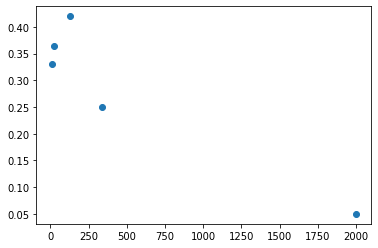

In [25]:
plt.scatter(sample['Permeability'].values, sample['Oil recovery factor'].values)

In [62]:
name1 = 'Porosity'
name2 = 'Permeability'
n = int((component(sample, [name1, name2], 'aic') + component(sample, [name1, name2], 'bic'))/2)


In [63]:
n

7

In [58]:
name1 = 'Porosity'
name2 = 'Permeability'
n = int((component(new_data, [name1, name2], 'aic') + component(new_data, [name1, name2], 'bic'))/2)


In [64]:
n=7

In [65]:
colors = ["c", "m", "y", "g", "b", "r", '#d62728', "w", '#1f77b4', '#17becf']
c = random.sample(colors, n)

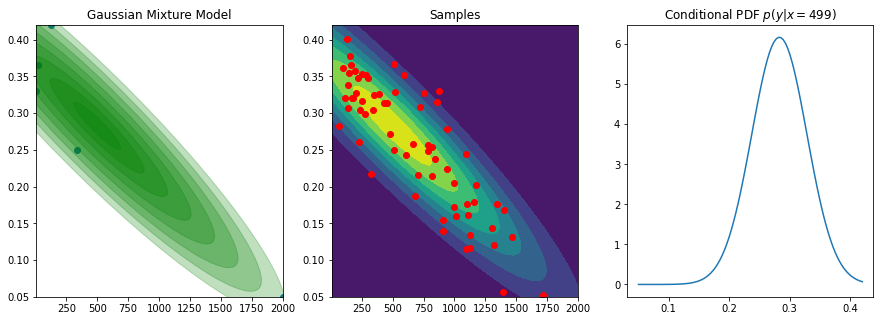

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from gmr.utils import check_random_state
from gmr import GMM, plot_error_ellipses


random_state = check_random_state(0)

n_samples = sample.shape[0]
n_features = 2
# X = np.ndarray((n_samples, n_features))
# X[:n_samples // 3, :] = random_state.multivariate_normal(
#     [0.0, 1.0], [[0.5, -1.0], [-1.0, 5.0]], size=(n_samples // 3,))
# X[n_samples // 3:-n_samples // 3, :] = random_state.multivariate_normal(
#     [-2.0, -2.0], [[3.0, 1.0], [1.0, 1.0]], size=(n_samples // 3,))
# X[-n_samples // 3:, :] = random_state.multivariate_normal(
#     [3.0, 1.0], [[3.0, -1.0], [-1.0, 1.0]], size=(n_samples // 3,))
X = sample[[name1, name2]].values
cond_number = round(np.mean(sample[name1].values))
gmm = GMM(n_components=n, random_state=random_state)
gmm.from_samples(X)
cond = gmm.condition(np.array([0]), np.array([cond_number]))
x_min = np.min(sample[name1].values)
x_max = np.max(sample[name1].values)
y_min = np.min(sample[name2].values)
y_max = np.max(sample[name2].values)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Gaussian Mixture Model")
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
plot_error_ellipses(plt.gca(), gmm, colors=c)
plt.scatter(X[:, 0], X[:, 1])

plt.subplot(1, 3, 2)
plt.title("Samples")
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
x, y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
X_test = np.vstack((x.ravel(), y.ravel())).T
p = gmm.to_probability_density(X_test)
p = p.reshape(*x.shape)
plt.contourf(x, y, p)
X_sampled = gmm.sample(100)
plt.scatter(X_sampled[:, 0], X_sampled[:, 1], c="r")

plt.subplot(1, 3, 3)
plt.title("Conditional PDF $p(y | x = "+str(cond_number)+" )$")
X_test = np.linspace(y_min, y_max, 100)
plt.plot(X_test, cond.to_probability_density(X_test[:, np.newaxis]))

plt.show()

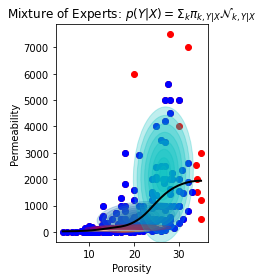

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from gmr.utils import check_random_state
from gmr import MVN, GMM, plot_error_ellipses


random_state = check_random_state(0)

n_samples = new_data.shape[0]
X = new_data[[name1, name2]].values


X_test = np.array(sorted(sample[name1].values))
X_point = sample[[name1, name2]].values

gmm = GMM(n_components=n, random_state=0)
gmm.from_samples(X)
Y = gmm.predict(np.array([0]), X_test[:, np.newaxis])

plt.subplot(1, 2, 2)
plt.title("Mixture of Experts: $p(Y | X) = \Sigma_k \pi_{k, Y|X} "
          "\mathcal{N}_{k, Y|X}$")
plt.scatter(X_point[:, 0], X_point[:, 1], c=['r'])
plt.scatter(X_point[ii, 0], X_point[ii, 1], c=['b'])
plt.xlabel(name1)
plt.ylabel(name2)
plot_error_ellipses(plt.gca(), gmm, colors=c)
plt.plot(X_test, Y.ravel(), c="k", lw=2)

plt.show()

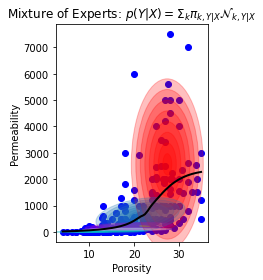

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from gmr.utils import check_random_state
from gmr import MVN, GMM, plot_error_ellipses


random_state = check_random_state(0)

n_samples = sample.shape[0]
X = sample[[name1, name2]].values


X_test = np.array(sorted(sample[name1].values))
X_point = sample[[name1, name2]].values

gmm = GMM(n_components=n, random_state=0)
gmm.from_samples(X)
Y = gmm.predict(np.array([0]), X_test[:, np.newaxis])

plt.subplot(1, 2, 2)
plt.title("Mixture of Experts: $p(Y | X) = \Sigma_k \pi_{k, Y|X} "
          "\mathcal{N}_{k, Y|X}$")
plt.scatter(X_point[:, 0], X_point[:, 1], c=['b'])
plt.xlabel(name1)
plt.ylabel(name2)
plot_error_ellipses(plt.gca(), gmm, colors=c)
plt.plot(X_test, Y.ravel(), c="k", lw=2)

plt.show()

In [10]:
def quantile2d(x,y,Nbins,nth):
    from numpy import percentile
    from scipy.stats import binned_statistic
    def myperc(x,n=nth):
        return(percentile(x,n))
    t=binned_statistic(x,y,statistic=myperc,bins=Nbins)
    return t

In [92]:
mquantiles(x, [0.95], axis=0).data[0]

array([989.926, 193.442,  30.   ])

In [91]:
s.data[0]

array([989.926, 193.442,  30.   ])

In [83]:
index_values = []
for i in range(data.shape[0]):
    if list(x[i]) < [989.926, 193.442]:
        index_values.append(i)

In [49]:
plt.plot(data['Gross'].values,data['Netpay'].values,'o',color='gray',ms=1,zorder=1)
#plt.plot(v,t.statistic,'r-',zorder=3)
plt.plot(data['Gross'].values[index_values],data['Netpay'].values[index_values],'o',color='blue',ms=1,zorder=2)

NameError: name 'index_values' is not defined

In [12]:
sample = data.sample(5)
sample.reset_index(inplace=True, drop=True)

In [14]:
sample[['Gross', 'Porosity']].values

array([[ 24.4,  13. ],
       [228.7,  11. ],
       [ 97.6,  16. ],
       [274.4,  18. ],
       [ 20.1,  19. ]])

In [19]:
len(data[['Netpay', 'Porosity']])

517

In [10]:
sample = data.loc[data['Hour'] == '0']
sample.reset_index(inplace=True, drop=True)

In [11]:
sample.shape

(8, 24)

In [11]:
sample = copy(data)

In [17]:
Nbins=5
nth=95.
y = sample['ws'].values
x = []
for u in ['wd', 'tp']:
    x.append(list(sample[u].values))
t =quantile2d(y,x,Nbins,nth)
ii=[]
for i in range(Nbins):
    for j in range(len(x)):
        ii=ii+np.argwhere(((t.binnumber==i) & (x[j]<t.statistic[j][i]))).flatten().tolist()
ii=np.array(ii,dtype=int)

In [34]:
ii_norm = []
for i in range(len(y)):
    if ii.count(i) == len(x):
        ii_norm.append(i)

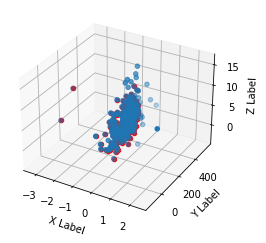

In [39]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')


xs = x[1]
ys = x[0]
zs = y
ax.scatter(xs, ys, zs)
for ind in ii_norm:
    ax.scatter(xs[ind], ys[ind], zs[ind], c=['r'])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [54]:
new_data = sample.loc[ii, :]
new_data.reset_index(inplace=True, drop=True)

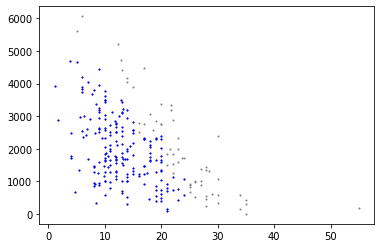

In [15]:
plt.plot(x,y,'o',color='gray',ms=1,zorder=1)
#plt.plot(v,t.statistic,'r-',zorder=3)
plt.plot(x[ii],y[ii],'o',color='blue',ms=1,zorder=2)

In [170]:
data_plot = np.transpose([data['ssr'].values])

In [171]:
ll = []
bic = []
aic = []
for i in range(1,11,1):
    gm = GaussianMixture(n_components=i, random_state=0)
    gm.fit(data_plot)
    ll_current = gm.lower_bound_
    bic_current = gm.bic(data_plot)
    aic_current = gm.aic(data_plot)
    ll.append(ll_current)
    bic.append(bic_current)
    aic.append(aic_current)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'BIC')

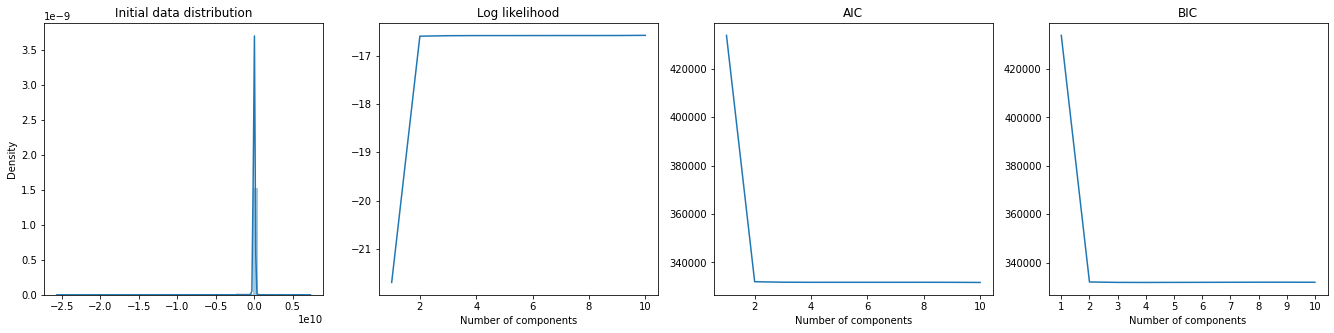

In [172]:
fig, axes = plt.subplots(1, 4, figsize=(23,5))


sns.distplot(data_plot, ax = axes[0])
axes[0].set_title('Initial data distribution')

axes[1].plot([i for i in range(1,11,1)], ll)
plt.xticks([i for i in range (1, 11, 1) ], [i for i in range (1, 11, 1)])
axes[1].set_xlabel('Number of components')
axes[1].set_title('Log likelihood')

axes[2].plot([i for i in range(1,11,1)], aic)
plt.xticks([i for i in range (1, 11, 1) ], [i for i in range (1, 11, 1)])
axes[2].set_xlabel('Number of components')
axes[2].set_title('AIC')

axes[3].plot([i for i in range(1,11,1)], bic)
plt.xticks([i for i in range (1, 11, 1) ], [i for i in range (1, 11, 1)])
axes[3].set_xlabel('Number of components')
axes[3].set_title('BIC')

In [13]:
def LRTS(data):
    n = 0
    p_val = []
    labels = []
    for i in range (1, 10, 1):
        gm1 = GaussianMixture(n_components=i, random_state=0)
        gm2 = GaussianMixture(n_components=i+1, random_state=0)
        gm1.fit(data)
        ll1 = np.mean(gm1.score_samples(data))
        gm2.fit(data)
        ll2 = np.mean(gm2.score_samples(data))
        LR = 2*(ll2 - ll1)
        p = chi2.sf(LR, 1)    
        p_val.append(p)
        labels.append('('+str(i)+','+str(i+1)+')')
    return p_val, labels

In [14]:
def lrts_comp(data):
    n = 0
    biggets_p = -1*np.infty
    comp_biggest = 0
    for i in range (1, 10, 1):
        gm1 = GaussianMixture(n_components=i, random_state=0)
        gm2 = GaussianMixture(n_components=i+1, random_state=0)
        gm1.fit(data)
        ll1 = np.mean(gm1.score_samples(data))
        gm2.fit(data)
        ll2 = np.mean(gm2.score_samples(data))
        LR = 2*(ll2 - ll1)
        p = chi2.sf(LR, 1)    
        if p > biggets_p:
            biggets_p = p
            comp_biggest = i
        n = comp_biggest
    
    return n

In [175]:
p, label = LRTS(data_plot)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'p_values of LRTS')

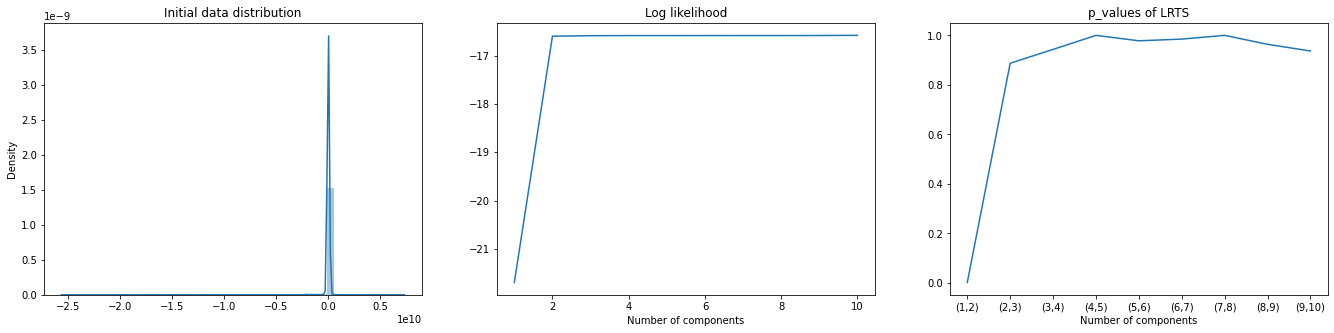

In [176]:
fig, axes = plt.subplots(1, 3, figsize=(23,5))


sns.distplot(data_plot, ax = axes[0])
axes[0].set_title('Initial data distribution')

axes[1].plot([i for i in range(1,11,1)], ll)
plt.xticks([i for i in range (1, 11, 1) ], [i for i in range (1, 11, 1)])
axes[1].set_xlabel('Number of components')
axes[1].set_title('Log likelihood')

axes[2].plot([i for i in range(len(p))], p)
plt.xticks([i for i in range (len(p)) ], label)
axes[2].set_xlabel('Number of components')
axes[2].set_title('p_values of LRTS')


In [15]:
def mix_norm_cdf(x, weights, means, covars):
    mcdf = 0.0
    for i in range(len(weights)):
        mcdf += weights[i] * stats.norm.cdf(x, loc=means[i][0], scale=covars[i][0][0])
    return mcdf

In [16]:
def theoretical_quantile (data, n_comp):
    model = GaussianMixture(n_components=n_comp,random_state=0)
    model.fit(data)
    q = []
    x = []
    #step =  ((np.max(model.sample(100000)[0])) - (np.min(model.sample(100000)[0])))/1000
    step =  (np.max(data) - np.min(data))/1000
    d = np.arange(np.min(data),np.max(data), step)
    for i in d:
        x.append(i)
        q.append(mix_norm_cdf(i,model.weights_, model.means_, model.covariances_))
    return x, q


In [17]:
def quantile_mix(p, vals, q):
    ind = q.index(min(q, key=lambda x:abs(x-p)))
    return vals[ind]

In [18]:
def probability_mix(val, vals, q):
    ind = vals.index(min(vals, key=lambda x:abs(x-val)))
    return(q[ind])

In [181]:
mcdf = [[] for i in range(3)]
x = [[] for i in range(3)]
n_comp = [1, 2, 3]
for j, n in enumerate(n_comp):
    model = GaussianMixture(n_components=n).fit(data_plot)
    #step =  ((np.max(model.sample(100000)[0])) - (np.min(model.sample(100000)[0])))/1000
    step =  (np.max(data_plot) - np.min(data_plot))/1000
    d = np.arange(np.min(data_plot),np.max(data_plot), step)
    for i in d:
        mcdf[j].append(mix_norm_cdf(i,model.weights_, model.means_, model.covariances_))
        x[j].append(i)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Mix cdf with 3 component')

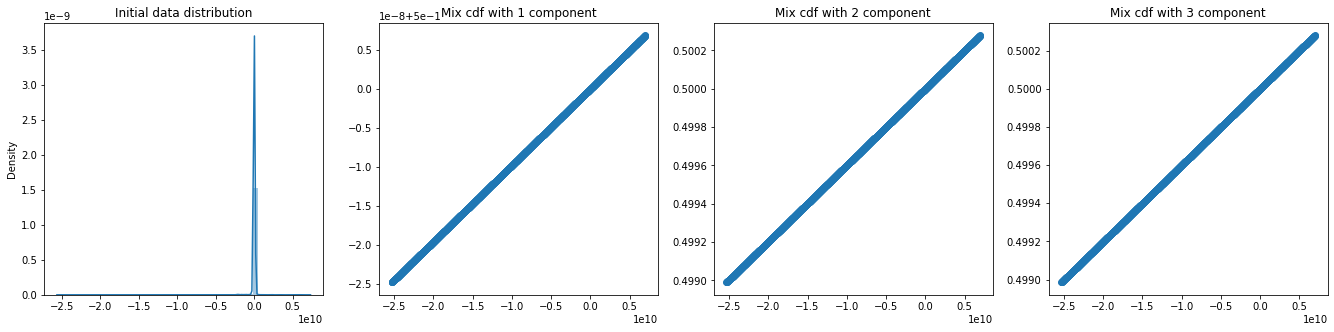

In [182]:
fig, axes = plt.subplots(1, 4, figsize=(23,5))


sns.distplot(data_plot, ax = axes[0])
axes[0].set_title('Initial data distribution')

axes[1].scatter(x[0], mcdf[0])
axes[1].set_title('Mix cdf with 1 component')

axes[2].scatter(x[1], mcdf[1])
axes[2].set_title('Mix cdf with 2 component')

axes[3].scatter(x[2], mcdf[2])
axes[3].set_title('Mix cdf with 3 component')

In [19]:
def sum_dist(data, vals, q):
    percs = np.linspace(1, 100, 10)
    x = np.quantile(data, percs/100)
    y = []
    for p in percs:
        y.append(quantile_mix(p/100, vals, q))
    dist = 0
    for xi,yi in zip(x,y):
        dist = dist + (abs(-1*xi + yi)) / math.sqrt(2)
    return dist

In [184]:
dists = []
for i in range (1, 11 ,1):
    vals, q = theoretical_quantile(data_plot, i)
    dists.append(sum_dist(data_plot, vals, q))

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


([<matplotlib.axis.XTick at 0x27a4fa9a4c0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

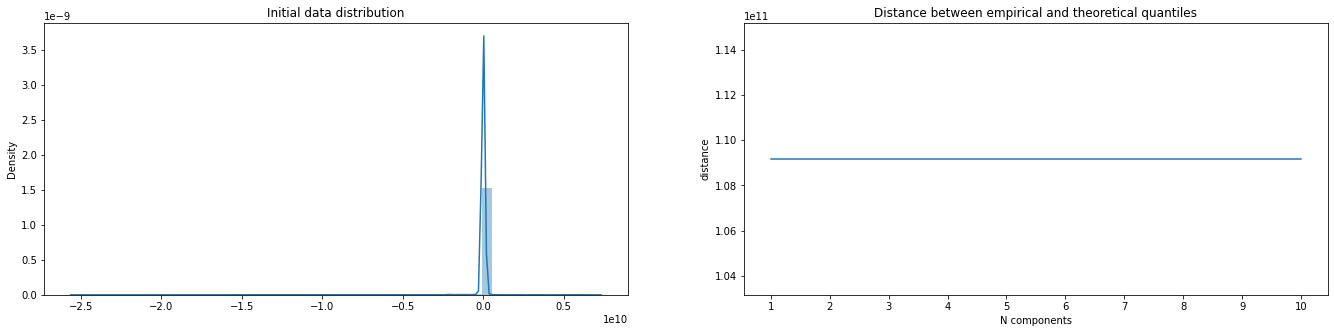

In [185]:
fig, axes = plt.subplots(1, 2, figsize=(23,5))


sns.distplot(data_plot, ax = axes[0])
axes[0].set_title('Initial data distribution')

axes[1].plot([i for i in range(1,11,1)], np.transpose(dists))
axes[1].set_title('Distance between empirical and theoretical quantiles')
axes[1].set_xlabel('N components')
axes[1].set_ylabel('distance')
plt.xticks([(i+1) for i in range (10) ], [(i+1) for i in range (10) ])

In [186]:
p_val = []
for i in range(10):
    vals, q = theoretical_quantile(data_plot, i+1)
    p_val.append(probability_mix(dists[i], vals, q))

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


([<matplotlib.axis.XTick at 0x27a4fddfb80>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

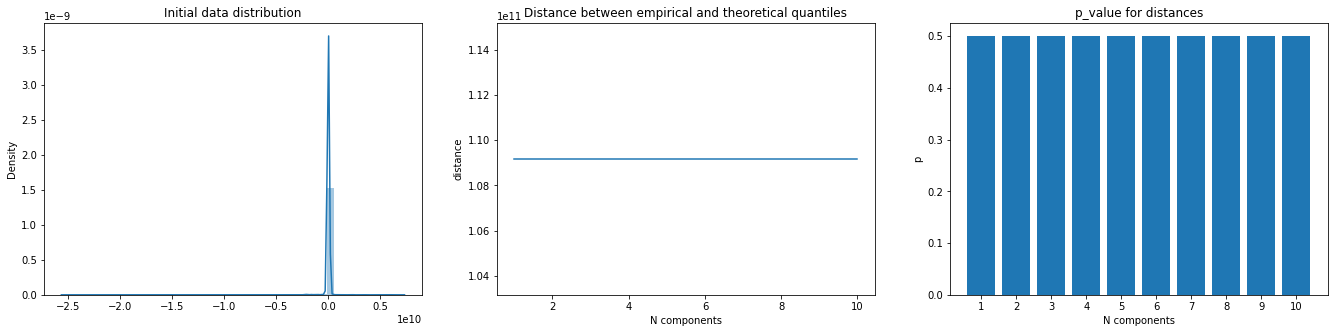

In [187]:
fig, axes = plt.subplots(1, 3, figsize=(23,5))


sns.distplot(data_plot, ax = axes[0])
axes[0].set_title('Initial data distribution')

axes[1].plot([i for i in range(1,11,1)], np.transpose(dists))
axes[1].set_title('Distance between empirical and theoretical quantiles')
axes[1].set_xlabel('N components')
axes[1].set_ylabel('distance')
plt.xticks([(i+1) for i in range (10) ], [(i+1) for i in range (10) ])


axes[2].bar([i for i in range(1,11,1)], p_val)
axes[2].set_title('p_value for distances')
axes[2].set_xlabel('N components')
axes[2].set_ylabel('p')
plt.xticks([(i+1) for i in range (10) ], [(i+1) for i in range (10) ])

In [20]:
def component (data, method):
    n = 1
    if method == 'aic':
        # gm = GaussianMixture(n_components=1, random_state=0)
        # gm.fit(data)
        # aic = gm.aic(data)
        # for i in range(2, 11, 1):
        #     gm = GaussianMixture(n_components=i, random_state=0)
        #     gm.fit(data)
        #     aic_current = gm.aic(data)
        #     if (aic - aic_current) > 100:
        #         aic = aic_current
        #         continue
        #     else:
        #         n = i-1
        #         break
        lowest_aic = np.infty
        comp_lowest = 0

        for i in range (1, 11, 1):
            gm1 = GaussianMixture(n_components=i, random_state=0)
            gm1.fit(data)
            aic1 = gm1.aic(data)
            if aic1 < lowest_aic:
                lowest_aic = aic1
                comp_lowest = i
            n = comp_lowest


           
        # if len(aics) == 0:
        #     n = 1
        # elif len(aics) == 1:
        #     n = 2
        # else:
        #     discrete_dists = []
        #     for i in range(0, len(aics)):
        #         sum1 = 0
        #         sum2 = 0
                
        #         for j in range(0, i):
        #             sum1 += (aics[j] - aics[j+1])
        #         for j in range(i, len(aics)-1):
        #             sum2 += (aics[j] - aics[j+1])
        #         discrete_dists.append(sum1 - sum2)
        #     n = discrete_dists.index(max(discrete_dists))
            
            
            


    if method == 'bic':
        # gm = GaussianMixture(n_components=1, random_state=0)
        # gm.fit(data)
        # bic = gm.bic(data)
        # for i in range(2, 11, 1):
        #     gm = GaussianMixture(n_components=i, random_state=0)
        #     gm.fit(data)
        #     bic_current = gm.bic(data)
        #     if (bic - bic_current) > 100:
        #         bic = bic_current
        #         continue
        #     else:
        #         n = i-1
        #         break
        lowest_bic = np.infty
        comp_lowest = 0

        for i in range (1, 11, 1):
            gm1 = GaussianMixture(n_components=i, random_state=0)
            gm1.fit(data)
            bic1 = gm1.bic(data)
            if bic1 < lowest_bic:
                lowest_bic = bic1
                comp_lowest = i
            n = comp_lowest


    if method == 'LRTS':
        n = lrts_comp(data)
    if method == 'quantile':
        biggest_p = -1*np.infty
        comp_biggest = 0
        for i in range(1, 11, 1):
            vals, q = theoretical_quantile(data, i)
            dist = sum_dist(data, vals, q)
            p = probability_mix(dist, vals, q)
            if p > biggest_p:
                biggest_p = p
                comp_biggest = i
        n = comp_biggest
        # vals, q = theoretical_quantile(data, 1)
        # dist = sum_dist(data, vals, q)
        # p = probability_mix(dist, vals, q)
        # if p > 0.8:
        #     n = 1
        # else:
        #     for i in range (2, 11 ,1):
        #         vals, q = theoretical_quantile(data, i)
        #         dist_current = sum_dist(data_plot, vals, q)
        #         if dist_current > dist:
        #             n = i - 1
        #             break
        #         else:
        #             if probability_mix(dist_current, vals, q) > 0.8:
        #                 n = i
        #                 break
        #             else:
        #                 dist = dist_current
        #                 continue

    
    return n


In [247]:
data = pd.read_csv('../data/mehra.csv')
data

,Region,Zone,Type,Year,Season,Month,Day,Hour,Latitude,Longitude,...,tp,blh,ssr,CVD60,no2,o3,so2,co,pm10,pm2.5
0,Yorkshire and The Humber,West Midlands Urban Area,Background Urban,1988,Winter,3,26,9,52.829361,-1.726818,...,0.000784,992.501830,5.133717e+05,0.205020,61.974631,17.740408,13.813847,1.442624,36.486336,18.646589
1,North West,Greater London Urban Area,Background Rural,1995,Spring,8,2,19,51.377194,-2.745956,...,0.000130,1086.774403,1.149178e+07,0.246176,83.165539,32.657576,22.427120,1.273507,34.964375,18.643421
2,West Midlands,North West & Merseyside,Background Urban,1997,Spring,3,14,4,52.002869,-2.760588,...,0.000209,683.612000,-1.076695e+01,0.181319,76.460115,17.692036,13.803708,1.442563,36.458572,18.645740
3,South East,Greater London Urban Area,Traffic Urban,1994,Winter,3,3,18,54.061788,-2.439756,...,0.000996,1252.022401,3.290441e+06,0.201057,85.786023,17.749945,26.277995,1.793299,36.543445,18.641970
4,South East,Greater London Urban Area,Background Urban,1997,Fall,8,15,18,54.570412,-1.460727,...,-0.000691,1730.349463,8.348839e+06,0.175219,48.424476,83.015267,-0.018112,0.359330,38.317914,18.640665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Yorkshire and The Humber,North West & Merseyside,Background Urban,1993,Spring,7,3,0,51.502964,0.300996,...,0.003594,193.882528,4.162147e+06,0.175375,76.300697,17.760820,13.802362,1.442467,36.448082,18.639546
9996,Greater London Authority,Eastern,Traffic Urban,1997,Winter,4,27,3,52.740712,-0.547268,...,0.001259,28.284668,-2.723962e+05,0.282495,-97.144486,17.749629,13.818443,1.385102,36.086071,18.642884
9997,East Midlands,Greater London Urban Area,Traffic Urban,1985,Summer,7,4,23,53.554519,-1.734243,...,0.002055,407.258881,1.815961e+06,0.134340,78.544941,17.735576,13.808181,1.442177,36.476172,18.645422
9998,Yorkshire and The Humber,West Midlands,Background Urban,1990,Fall,10,20,20,51.180594,0.098250,...,0.000620,35.156433,1.742372e+06,0.219353,76.320929,17.742210,13.792902,1.442187,36.480802,18.642345


In [248]:
data.columns

Index(['Region', 'Zone', 'Type', 'Year', 'Season', 'Month', 'Day', 'Hour',
       'Latitude', 'Longitude', 'Altitude', 't2m', 'ws', 'wd', 'tp', 'blh',
       'ssr', 'CVD60', 'no2', 'o3', 'so2', 'co', 'pm10', 'pm2.5'],
      dtype='object')

In [272]:
data_plot = np.transpose([data['co'].values])

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

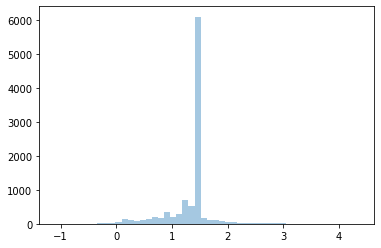

In [273]:
sns.distplot(data_plot, kde=False)

In [274]:
component(data_plot, 'aic')

10

In [275]:
component(data_plot, 'bic')

10

In [276]:
component(data_plot, 'LRTS')

2

In [277]:
component(data_plot, 'quantile')

3

In [196]:
methods = ['aic', 'bic', 'LRTS', 'quantile']

In [290]:
metric = [[] for i in range(4)]
for c in columns_for_disc:
    data_plot = np.transpose([data[c].values])
    for ind, m in enumerate(methods):
        start = time.time()
        n = component(data_plot, m)
        end = time.time()
        metric[ind].append((end-start)/n)

Text(0, 0.5, 'Time / Number of components')

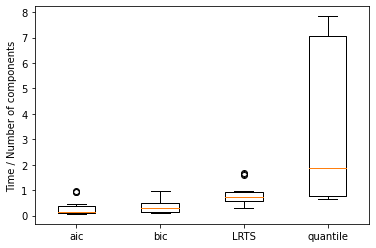

In [291]:
plt.boxplot(metric)
plt.xticks([(i+1) for i in range (4) ], methods)
plt.ylabel('Time / Number of components')